In [1]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

In [2]:
np.random.seed(0)

In [3]:
#Loading data
df_train = pd.read_csv('C:/Users/Piyush/SDL Mini Project/airbnbdata/train_users_2.csv')
df_test = pd.read_csv('C:/Users/Piyush/SDL Mini Project/airbnbdata/test_users.csv')
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
id_test = df_test['id']
piv_train = df_train.shape[0]

In [4]:
#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [5]:
#Removing id and date_first_booking
df_all = df_all.drop(['id', 'date_first_booking'], axis=1)

In [6]:
#Filling nan
df_all = df_all.fillna(-1)

In [7]:
df_all.tail()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
275542,2014-09-30,20140930235232,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
275543,2014-09-30,20140930235306,-unknown-,-1.0,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
275544,2014-09-30,20140930235408,-unknown-,-1.0,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
275545,2014-09-30,20140930235430,-unknown-,-1.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
275546,2014-09-30,20140930235901,FEMALE,49.0,basic,0,en,other,other,tracked-other,Web,Windows Desktop,Chrome


In [8]:
#####Feature engineering#######
#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis=1)

In [9]:
dac

array([[2010,    6,   28],
       [2011,    5,   25],
       [2010,    9,   28],
       ...,
       [2014,    9,   30],
       [2014,    9,   30],
       [2014,    9,   30]])

In [10]:
df_all['dac_year']

0         2010
1         2011
2         2010
3         2011
4         2010
          ... 
275542    2014
275543    2014
275544    2014
275545    2014
275546    2014
Name: dac_year, Length: 275547, dtype: int32

In [11]:
df_all['dac_day']

0         28
1         25
2         28
3          5
4         14
          ..
275542    30
275543    30
275544    30
275545    30
275546    30
Name: dac_day, Length: 275547, dtype: int32

In [12]:
df_all.head()

,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day
0,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28
3,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5
4,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14


In [13]:
#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

In [14]:
tfa

array([[2009,    3,   19,    4,   32,   55],
       [2009,    5,   23,   17,   48,    9],
       [2009,    6,    9,   23,   12,   47],
       ...,
       [2014,    9,   30,   23,   54,    8],
       [2014,    9,   30,   23,   54,   30],
       [2014,    9,   30,   23,   59,    1]])

In [15]:
df_all['tfa_year']

0         2009
1         2009
2         2009
3         2009
4         2009
          ... 
275542    2014
275543    2014
275544    2014
275545    2014
275546    2014
Name: tfa_year, Length: 275547, dtype: int32

In [16]:
df_all.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5,2009,10,31
4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14,2009,12,8


In [17]:
#Age
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

In [18]:
av

array([-1., 38., 56., ..., -1., -1., 49.])

In [19]:
df_all.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5,2009,10,31
4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14,2009,12,8


In [20]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

In [21]:
df_all.head()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,-1.0,2010,6,28,2009,3,19,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,2011,5,25,2009,5,23,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,56.0,2010,9,28,2009,6,9,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,2011,12,5,2009,10,31,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,2010,9,14,2009,12,8,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
pd.set_option('display.max_columns', None)
df_all.head()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_-1,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,-1.0,2010,6,28,2009,3,19,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,2011,5,25,2009,5,23,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0

In [23]:
#Splitting train and test
vals = df_all.values
X = vals[:piv_train]
le = LabelEncoder()
y = le.fit_transform(labels)   
X_test = vals[piv_train:]

In [24]:
#Classifier
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(X, y)
y_pred = xgb.predict_proba(X_test)

In [25]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [27]:
#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [28]:
sub.head()

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

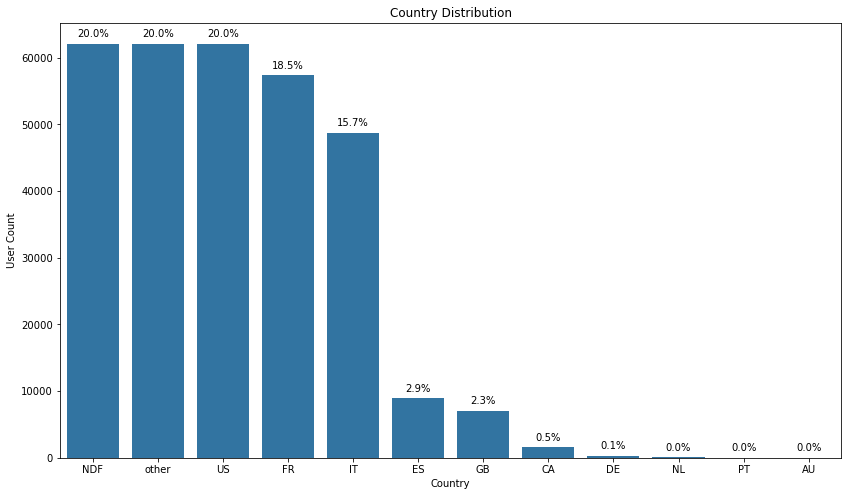

In [30]:
#Finding the Country distribution
plt.figure(figsize=(14,8))
order1 = sub['country'].value_counts().index
sns.countplot(data = sub,x='country',order=order1,color=sns.color_palette()[0])
plt.xlabel('Country')
plt.ylabel('User Count')
plt.title('Country Distribution')
order2 = sub['country'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count/sub.shape[0])
    plt.text(i,count+1000,strt,ha='center')